<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/Gensim_implementation_of_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective:

Business often possesses large amount of text documents such as customer reviews, technician logs or legal documents. To find potential business opprtunities, data scientists utilize topic modeling techniques which often provide quick ways of gaining insights from large amount of text documents. LDA model is one of most popular unsupervised learning approches that help achieving this goal when there are no pre-known topics. Popular data scinece packages such as Gensim, Mallet and Scikit-learn provide such implementation. The exercise in this notebook demonstrates this powerful analysis by utilizing Gensim LDA implementations to extract topics from '20 news group' data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install additioanal Packages
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 15.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=2071b82febc47ebe0362091474edb8faaecf017349e17acb0a3b1bb73a982d2a
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=fa25c80f303c333aa94bf8fc21949cf7127e0a3a1daf426c2d76b78966b24ccd
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
from glob import glob
import re, string
import pandas as pd
import numpy as np

from gensim.utils import simple_preprocess
from gensim import models
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.phrases import Phrases, Phraser

import spacy
!python -m spacy download en_core_web_lg

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from gensim.models import CoherenceModel

import pyLDAvis.gensim as gensimvis
import pyLDAvis

import matplotlib.pyplot as plt

     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=eb5d3d1af4bcdd7ec51c07630ac4cc7173725c4431d3015b534dc844e6e1724c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ms9cxly9/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

# Examine data
print('20 Unique Topics:  ', df.target_names.unique())
print('Number of Documents:  ', len(df.content), 'documents')
df.head()


20 Unique Topics:   ['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']
Number of Documents:   11314 documents


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


Though the study is focused on unsupervised learning (assume no pre-known document labels), let's cheat a little by peeking into the given groups so we roughly know how many groups to expect from the optimized model.

In [ ]:
known_topic_dist=df.target_names.value_counts().reset_index()
known_topic_dist.columns = ['Category', 'Document Num']
known_topic_dist

,Category,Document Num
0,rec.sport.hockey,600
1,soc.religion.christian,599
2,rec.motorcycles,598
3,rec.sport.baseball,597
4,sci.crypt,595
5,sci.med,594
6,rec.autos,594
7,sci.space,593
8,comp.windows.x,593
9,comp.os.ms-windows.misc,591


In [ ]:
# Initial text data preparation:
# Convert to list
docs_raw = df.content.values.tolist()

def data_preparation(docs_list):
# Remove Emails
  docs_list  = [re.sub(r'\S*@\S*\s?', '', sent) for sent in docs_list ]
# Remove new line characters
  docs_list  = [re.sub(r'\s+', ' ', sent) for sent in docs_list]
# Remove distracting single quotes
  docs_list  = [re.sub(r"\'", "", sent) for sent in docs_list ]
# Tokenize
  docs_list  = [simple_preprocess(sent, min_len=3) for sent in docs_list ]
  return docs_list

docs_list=data_preparation(docs_raw)



In [ ]:
# Train the bigram and trigram models
bigram = Phrases(docs_list, min_count=10, threshold=4) # higher threshold fewer phrases.
trigram = Phrases(bigram[docs_list], min_count=10, threshold=4)  

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Prepare stop word list (NLTK)
# It depends on nature of document to decide stop word list. E.g. If doucment contains term 'New York', new should not be treated as a stop word.
stop_words = stopwords.words('english')
stop_words.extend(["max", "thanks","just", "right", "like", 'from', 'subject', 're', 'use'])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Stop words were still included in the trained n-gram model, but will not be reflected in the processed docs since stop words are removed first.
# It may be not recommended to remove the stop words before n-gran training. 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#    """https://spacy.io/api/annotation"""
    
#    texts_out = []
#    for sent in texts:
#        doc = nlp(" ".join(sent)) 
#        texts_out.append([token.lemma_ for token in doc]) # if only keep the tokens with given posttags, add 'if token.pos_ in allowed_postags'
#    return texts_out

# Visually compared NLTK and Gensim based lemmetization results, prefered NLTK results. 


In [ ]:
# NLTK Lemmetizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# Call functions

# Remove Stop Words
data_words_nostops = remove_stopwords(docs_list)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Lemmatization
Data_Lemmatized=[]
holder=[]
for i in data_words_trigrams:
  holder=[]
  for j in i:
    holder.append(WordNetLemmatizer().lemmatize(j, get_wordnet_pos(j)))
  Data_Lemmatized.append(holder)
  
# Lemmatization may create new stop words, another round of stopword removing maybe used after lemmatization if causing too much disturbance. 



In [ ]:
# Create Dictionary and Corpus

dictionary=Dictionary(data_lemmatized)
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=None)
dictionary.compactify() # re-assign id

corpus = [dictionary.doc2bow(i) for i in data_lemmatized]

In [ ]:
# Save the Dictionary and Corpus
dictionary.save('/content/drive/My Drive/newsgroup_dictionary.dict')  # save dict to disk
MmCorpus.serialize('/content/drive/My Drive/newsgroup_corpus.mm', corpus)  # save corpus to disk

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Load the saved Dictiaonry and Corpus
dictionary_reload = corpora.Dictionary.load('/content/drive/My Drive/newsgroup_dictionary.dict')
corpus_reload = corpora.MmCorpus('/content/drive/My Drive/newsgroup_corpus.mm')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Find the optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') #{'u_mass', 'c_v', 'c_uci', 'c_npmi'}
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_reload, corpus=corpus_reload, texts=Data_Lemmatized, start=3, limit=27, step=2)

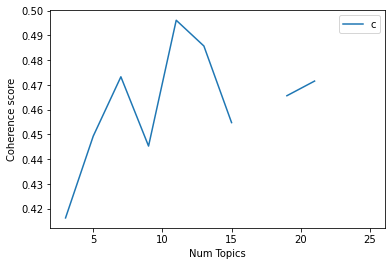

In [ ]:
# Show graph
start=3; limit=27; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
# model_list[4] the optimal model

Num Topics = 3  has Coherence Value of 0.4163
Num Topics = 5  has Coherence Value of 0.4493
Num Topics = 7  has Coherence Value of 0.4733
Num Topics = 9  has Coherence Value of 0.4453
Num Topics = 11  has Coherence Value of 0.4961
Num Topics = 13  has Coherence Value of 0.4857
Num Topics = 15  has Coherence Value of 0.4548
Num Topics = 17  has Coherence Value of nan
Num Topics = 19  has Coherence Value of 0.4656
Num Topics = 21  has Coherence Value of 0.4715
Num Topics = 23  has Coherence Value of nan
Num Topics = 25  has Coherence Value of 0.4659


Cohenrence scores recommend 17 topics as optimal number of topics.

In [ ]:
def perplexity_values(dictionary, corpus, texts, limit, start=4, step=3):
    perplex_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=50, passes=20)

        model_list.append(model)
        perplexmodel = model.log_perplexity(corpus)
        perplex_values.append(perplexmodel)

    return model_list, perplex_values

In [ ]:
%%time
model_list, perplex_values = perplexity_values(dictionary=dictionary_reload, corpus=corpus_reload, texts=Data_Lemmatized, start=9, limit=31, step=2)

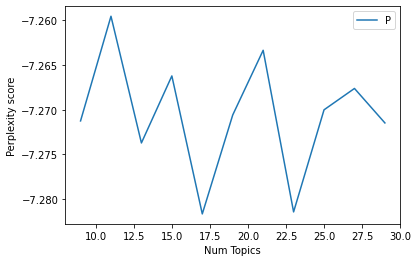

In [ ]:
# Show graph
start=9; limit=31; step=2;
x = range(start, limit, step)
plt.plot(x, perplex_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("Perplexity_values"), loc='best')
plt.show()

Perplexity score is used as a secondary verification in terms of recommended topic numbers. Though not necessary agree with the cohenrence score based recommendation, 11 topics is again recommended as the optimal topic numbers.

In [ ]:
%%time
lda = models.ldamodel.LdaModel(corpus=corpus_reload, id2word=dictionary_reload, num_topics=11, passes=20)
# use the corpus and dictionary to set up the lda model 
# instead of refit, can directly use model_list[4] since it's the trained optimal model

lda.save('/content/drive/My Drive/newsgroups_11_lda.model')
# same the ran model

In [ ]:
# visualization

vis_data = gensimvis.prepare(lda, corpus_reload, dictionary_reload, mds='mmds', sort_topics=False) #mds='mmds'/'tsne'/'pcoa' for dimension reduction # 3 components- fitted model, corpus(term_id, count), dictionary
pyLDAvis.display(vis_data)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Summarize 11 topics by learnings from the pyLDAvis graph:

Topic 1: Religion related

Topic 2: Crime

Topic 3: Health & Medicine related

Topic 4: Sports/Sport teams (Hockey, Basketball)

Topic 5:  Gun laws

Topic 6: Cyber security/privacy

Topic 7: Politics- activities against war

Topic 8: Space science 

Topic 9: Computer graphics 

Topic 10: Automobiles

Topic 11: Motorvehicles

Comparing to the 20 known topics below, the 11 naturally learned topics have a lot in common. **The size of each circle** represents relative document size within, the **relative distance** between topics represents how closely they are related to each other.


## Finding the dominant topic in each sentence:

Code below finds the dominant topic for each document by finding the topic having the highest % contribution in that document. (Setting all topic contribution in one document adding up to one.)

In [ ]:
def format_topics_sentences(ldamodel=lda, corpus=corpus_reload, texts=docs_raw):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus_reload, texts=docs_raw)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4122,"get, would, make, think, say, know, people, ta...",From: lerxst@wam.umd.edu (where's my thing)\nS...
1,1,9.0,0.8945,"system, drive, card, use, would, price, get, s...",From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,2,9.0,0.2996,"system, drive, card, use, would, price, get, s...",From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,3,8.0,0.3203,"say, would, people, go, get, see, come, think,...",From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,4,7.0,0.6955,"file, window, program, use, problem, line, run...",From: jcm@head-cfa.harvard.edu (Jonathan McDow...
5,5,3.0,0.4764,"gun, law, case, state, crime, may, study, use,...",From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...
6,6,0.0,0.5093,"get, would, make, think, say, know, people, ta...",From: bmdelane@quads.uchicago.edu (brian manni...
7,7,9.0,0.6562,"system, drive, card, use, would, price, get, s...",From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...
8,8,7.0,0.9351,"file, window, program, use, problem, line, run...",From: holmes7000@iscsvax.uni.edu\nSubject: WIn...
9,9,9.0,0.5414,"system, drive, card, use, would, price, get, s...",From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...


## Present most representative documents for each topic:
This summary table helps finding most representative documents from raw data that represent each of the learned topics.


In [ ]:
Num_doc=1 # Top n document for each topic

sent_topics = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics= pd.concat([sent_topics, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(Num_doc)],axis=0)

# Reset Index    
sent_topics.reset_index(drop=True, inplace=True)

# Format
sent_topics.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics.head(20)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9567,"get, would, make, think, say, know, people, ta...",From: astein@nysernet.org (Alan Stein)\nSubjec...
1,1.0,0.9840,"car, get, would, problem, engine, drive, use, ...",From: rwf2@ns1.cc.lehigh.edu (ROBERT WILLIAM F...
2,2.0,0.9697,"bike, power, ride, use, would, get, wire, work...",From: gould@waterloo.hp.com (Dan Gould)\nSubje...
3,3.0,0.9173,"gun, law, case, state, crime, may, study, use,...",From: jim@specialix.com (Jim Maurer)\nSubject:...
4,4.0,0.9304,"government, would, people, year, state, work, ...",From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...
5,5.0,0.9879,"game, team, play, player, win, year, get, woul...",From: rauser@fraser.sfu.ca (Richard John Rause...
6,6.0,0.9882,"key, information, use, chip, may, entry, syste...",From: spworley@netcom.com (Steve Worley)\nSubj...
7,7.0,0.9909,"file, window, program, use, problem, line, run...",From: ge!severy%severy@uunet.UU.NET (severy)\n...
8,8.0,0.9877,"say, would, people, go, get, see, come, think,...",From: roby@chopin.udel.edu (Scott W Roby)\nSub...
9,9.0,0.9838,"system, drive, card, use, would, price, get, s...",From: richk@grebyn.com (Richard Krehbiel)\nSub...


## Document distribution across Topics

Summary below numerically shows Autovehicle is the smallest topic with 695 related documents and Religion is the largest topic with 1,645 related documents. The relative size of the documents can also be observed in pyLDAvis graph.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"get, would, make, think, say, know, people, ta...",695,0.0614
1.0,1.0,"car, get, would, problem, engine, drive, use, ...",808,0.0714
2.0,2.0,"bike, power, ride, use, would, get, wire, work...",492,0.0435
3.0,3.0,"gun, law, case, state, crime, may, study, use,...",395,0.0349
4.0,4.0,"government, would, people, year, state, work, ...",651,0.0575
5.0,5.0,"game, team, play, player, win, year, get, woul...",988,0.0873
6.0,6.0,"key, information, use, chip, may, entry, syste...",698,0.0617
7.0,7.0,"file, window, program, use, problem, line, run...",1832,0.1619
8.0,8.0,"say, would, people, go, get, see, come, think,...",1363,0.1205
9.0,9.0,"system, drive, card, use, would, price, get, s...",1747,0.1544


## Conclusion:

Gensim implementation provides the better (more detailed topics and higher cohenerence score) comparing to sk-learn approch. Resulted groups are able to capture most detailed subjects known from documents.

To enhence its performance, next step may include but not limited to more detailed text pre-processing, increase model training iteration, use tf-idf vectorizer instead of simple term frequency vectorizer or try the Mallet model used in another exercise.
